In [2]:
from __future__ import print_function
import keras
import os
from keras.preprocessing.image import ImageDataGenerator

num_classes = 2
img_rows, img_cols = 48, 48
batch_size = 1024
epochs = 5

train_data_dir = './datasets/training'
validation_data_dir = './datasets/testing'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=False)

Using TensorFlow backend.


Found 222019 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.


In [3]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

model = Sequential()

inputShape = (img_rows, img_cols, 3)
            
# CONV => RELU => POOL
model.add(SeparableConv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
# (CONV => RELU => POOL) * 2
model.add(SeparableConv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(SeparableConv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU => POOL) * 3
model.add(SeparableConv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(SeparableConv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(SeparableConv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
 
# softmax classifier
model.add(Dense(num_classes))
model.add(Activation("softmax"))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

W0118 20:02:29.314571  9816 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0118 20:02:29.389253  9816 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0118 20:02:29.418703  9816 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0118 20:02:29.470044  9816 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0118 20:02:29.470044  9816 deprecation_wrapper.py:119] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 48, 48, 32)        155       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 24, 24, 64)        2400      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)        0         
__________

In [3]:
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Generate the plot
plot_model(model, to_file = 'cnn_architecture_karan.png',
           show_shapes = True,
           show_layer_names = True)

# Show the plot here
img = mpimg.imread('cnn_architecture_karan.png')
plt.figure(figsize=(400,200))
imgplot = plt.imshow(img) 

In [4]:
from keras.optimizers import RMSprop, SGD, Adagrad
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
                     
checkpoint = ModelCheckpoint("cancer_trained_model_checkpoint_karan.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

INIT_LR = 1e-2

# We use a very small learning rate 
model.compile(loss = 'binary_crossentropy',
              optimizer = Adagrad(lr=INIT_LR, decay=INIT_LR / epochs),
              metrics = ['accuracy'])

nb_train_samples = 222019
nb_validation_samples = 55505


W0117 04:08:45.568497  2208 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0117 04:08:45.587446  2208 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/5
216/216 [==============================] - 482s 2s/step - loss: 0.4257 - acc: 0.8328 - val_loss: 0.8800 - val_acc: 0.6065

Epoch 00001: val_loss improved from inf to 0.88001, saving model to cancer_trained_model_checkpoint_karan.h5
Epoch 2/5
216/216 [==============================] - 417s 2s/step - loss: 0.3368 - acc: 0.8577 - val_loss: 0.7084 - val_acc: 0.7654

Epoch 00002: val_loss improved from 0.88001 to 0.70838, saving model to cancer_trained_model_checkpoint_karan.h5
Epoch 3/5
216/216 [==============================] - 405s 2s/step - loss: 0.3239 - acc: 0.8633 - val_loss: 0.4153 - val_acc: 0.8460

Epoch 00003: val_loss improved from 0.70838 to 0.41529, saving model to cancer_trained_model_checkpoint_karan.h5
Epoch 4/5
216/216 [==============================] - 424s 2s/step - loss: 0.3186 - acc: 0.8656 - val_loss: 0.3801 - val_acc: 0.8610

Epoch 00004: val_loss improved from 0.41529 to 0.38014, saving model to cancer_trained_model_checkpoint_karan.h5
Epoch 5/5
216/216 [=

In [13]:
import pickle 

pickle_out = open("MNIST_history_karan.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [8]:
from keras.models import load_model
model = load_model('cancer_trained_model_checkpoint_karan.h5')

import pickle
pickle_in = open("MNIST_history_karan.pickle","rb")
saved_history = pickle.load(pickle_in)
print(saved_history)

{'val_loss': [0.8800129079156451, 0.7083759504526789, 0.41528688714848255, 0.38014160175498624, 0.39147082652320697], 'val_acc': [0.6065176504629629, 0.7653860978980336, 0.8460380682222132, 0.8609974118914518, 0.8634569850728712], 'loss': [0.4256969428172818, 0.3367817583054492, 0.3239429990938717, 0.3186409216437794, 0.3158915649457184], 'acc': [0.8328179253472222, 0.8577298128366735, 0.8632593497736086, 0.8655535193597487, 0.8670241407834124], 'lr': [0.01, 0.01, 0.01, 0.01, 0.01]}


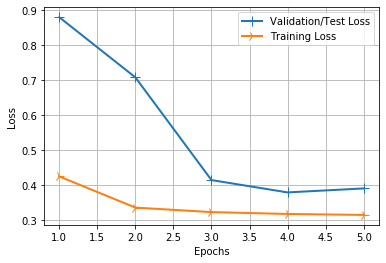

In [11]:
# Plotting our loss charts
import matplotlib.pyplot as plt

# history_dict = history.history

loss_values = saved_history['loss']
val_loss_values = saved_history['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

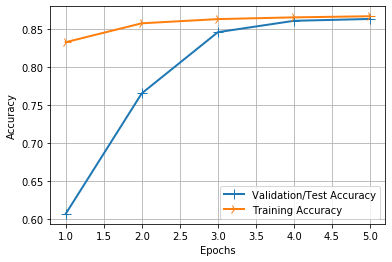

In [12]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

# history_dict = history.history

acc_values = saved_history['acc']
val_acc_values = saved_history['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Confusion Matrix
[[36257  3412]
 [ 4370 11466]]

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     39669
           1       0.77      0.72      0.75     15836

    accuracy                           0.86     55505
   macro avg       0.83      0.82      0.82     55505
weighted avg       0.86      0.86      0.86     55505



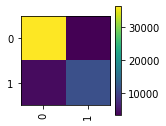

In [13]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 48,48,3
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

target_names = list(class_labels.values())
plt.figure(figsize=(2,2))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

print('\nClassification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [14]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = './datasets/testing/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

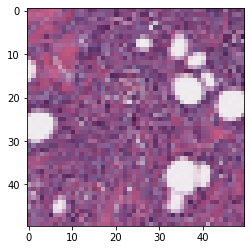

In [15]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

input_image_path = './datasets/testing/1/8863_idx5_x1501_y951_class1.png'

# Show our input Image for Feature visualization
img1 = image.load_img(input_image_path)
plt.imshow(img1);

img_size = (48, 48)
# load imamge into a 4D Tensor, convert it to a numpy array and expand to 4 dim
img1 = image.load_img(input_image_path, target_size = img_size)
image_tensor = image.img_to_array(img1)
#print(image_tensor.shape)
image_tensor = image_tensor/255
image_tensor = np.expand_dims(image_tensor, axis=0)
#print(img.shape)

In [16]:
from keras import models

# Extracts the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:9]]

# Creates a model that returns these outputs given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(image_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 48, 48, 32)


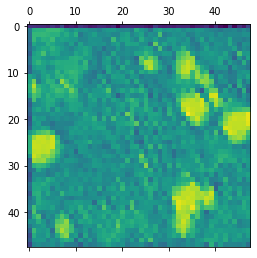

In [17]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

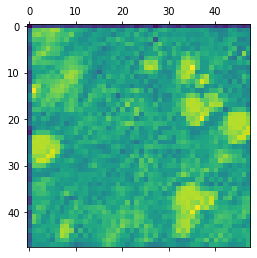

In [18]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


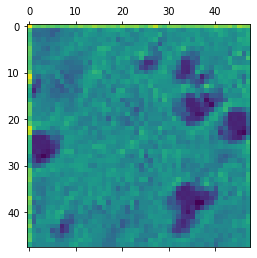

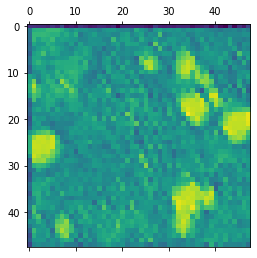

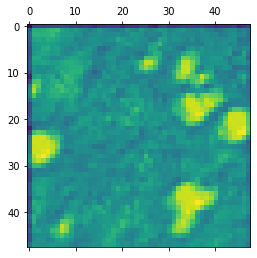

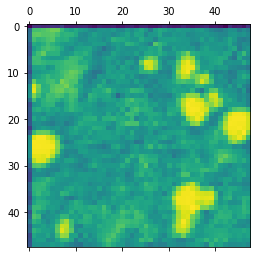

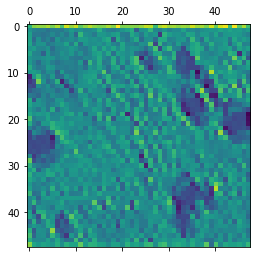

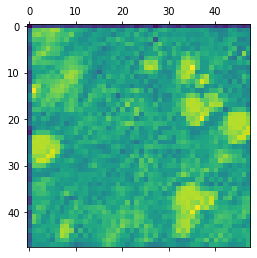

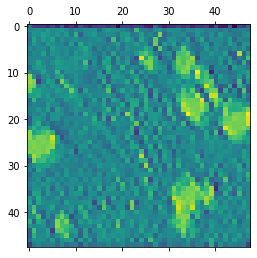

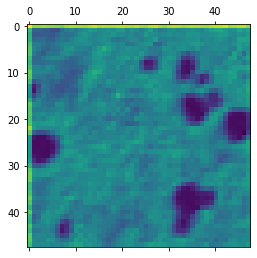

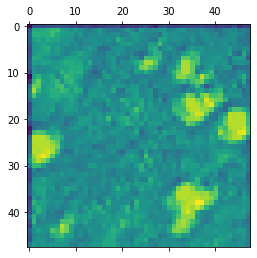

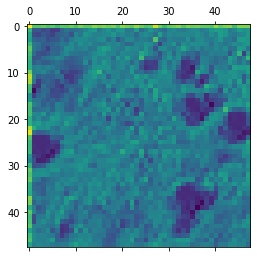

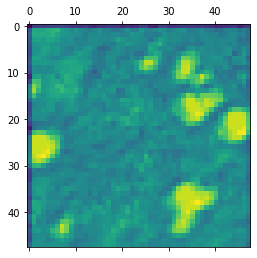

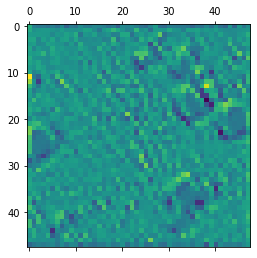

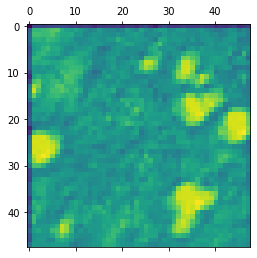

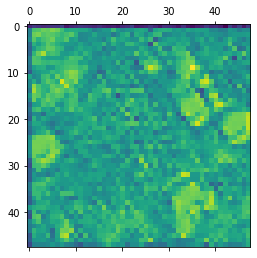

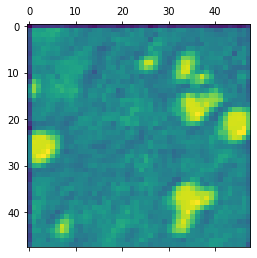

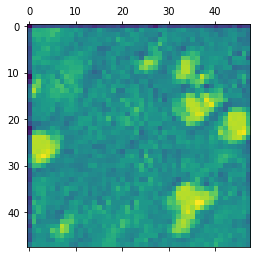

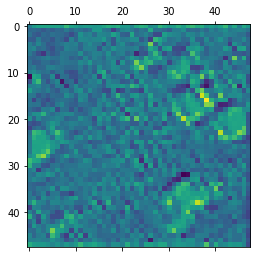

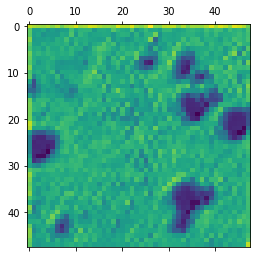

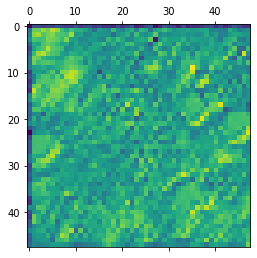

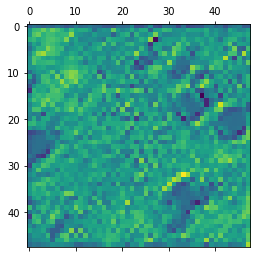

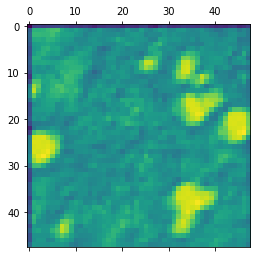

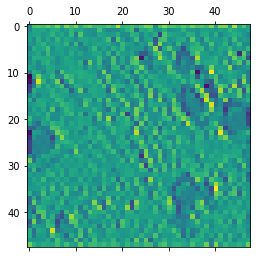

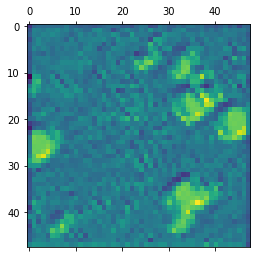

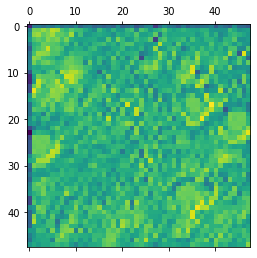

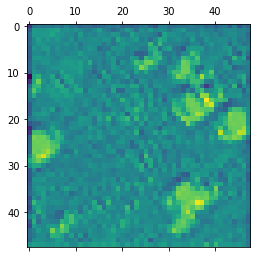

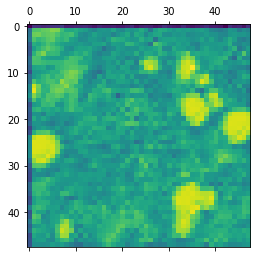

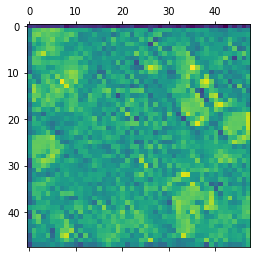

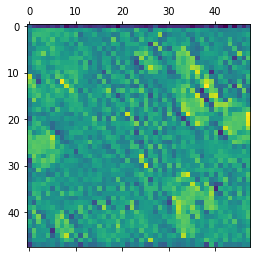

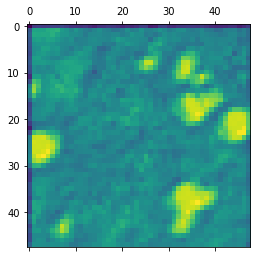

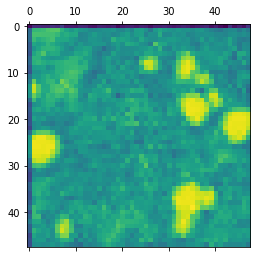

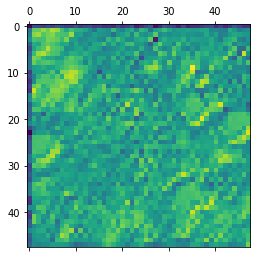

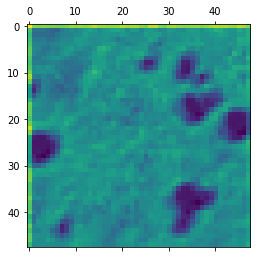

In [19]:
for i in range(0,32):
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')

['separable_conv2d_1', 'activation_1', 'batch_normalization_1', 'max_pooling2d_1', 'dropout_1', 'separable_conv2d_2', 'activation_2', 'batch_normalization_2', 'separable_conv2d_3']
['separable_conv2d_1', 'separable_conv2d_2', 'separable_conv2d_3']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


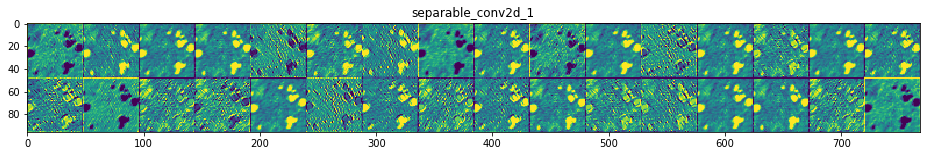

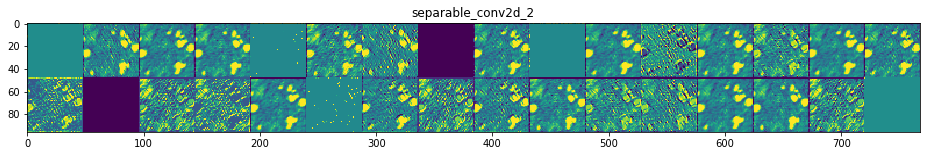

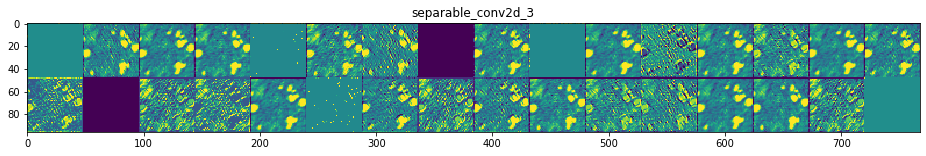

In [38]:


layer_names = []
for layer in model.layers[:9]:
    layer_names.append(layer.name)
images_per_row = 16

# Get CONV layers only
conv_layer_names = []
for layer_name in layer_names:
    if 'separable_conv2' in layer_name:
        conv_layer_names.append(layer_name)
print(layer_names)
print(conv_layer_names)

for layer_name, layer_activation in zip(conv_layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [1]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [4]:
import keras
print(keras.__version__)

2.2.4
